In [1]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\essmar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install statsmodels

You should consider upgrading via the 'C:\Users\essmar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install scikit-learn==1.0

You should consider upgrading via the 'C:\Users\essmar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor , GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV,  cross_validate, train_test_split, cross_val_score, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, RANSACRegressor, Lasso, Ridge, ElasticNet, QuantileRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import LinearSVR, SVR
import datetime
import joblib
import os
from sklearn.ensemble import VotingRegressor
from sklearn import __version__ as sklearn_version



#import shap


pd.set_option('display.max_columns', None) 



In [5]:
sac= pd.read_csv('../Data/stats_and_contracts.csv')
skaters= sac.query('(Pos_G==0)')
skaters= skaters.drop(columns=['GS','W','L','TplusOTL','GA','GA','SV','SA','SV_Pct','GAA','SUT','GPS','MIN','QS','RBS','TYPE', 'Pos_G'])
skaters['AGE']= skaters['AGE'].astype(float)
skaters['AAV']= skaters['AAV'].astype(float)
skaters= skaters.dropna()
skaters= skaters.reset_index()

forwards= pd.read_csv('../Data/forwards_final.csv')
defense= pd.read_csv('../Data/defense_final.csv')
goalies=pd.read_csv('../Data/goalies_final.csv')

In [6]:
skaters= skaters.drop(columns=['index','Unnamed: 0'])
forwards= forwards.drop(columns='Unnamed: 0')
defense= defense.drop(columns='Unnamed: 0')
goalies= goalies.drop(columns='Unnamed: 0')

In [7]:
skaters.head()

,Player,Season,AGE,Pos_C,Pos_LW,Pos_RW,Pos_D,GP,G,A,PTS,PPG,PlusMinus,ATOI,TOI(EV),PIM,PS,EV_A,PP_A,SH_A,GW,S,S_Pct,BLK,HIT,FOW,FOL,FO_Pct,CF,CA,CF_Pct,CF_Pct_rel,FF,FA,FF_Pct,FF_Pct_rel,oiSH_Pct,oiSV_Pct,PDO,oZS_Pct,dZS_Pct,TK,GV,SAtt.,Thru_Pct,SOT_Att,SOT_Scored,SOT_Saved,SOT_Pct,LENGTH,AAV
0,Wayne Simmonds,2021,32.0,0,1,1,0,61.666667,10.666667,10.666667,21.333333,0.345946,-13.333333,14.188889,12.458333,70.000000,1.166667,6.333333,4.333333,0.000000,1.000000,112.666667,9.600000,24.000000,115.333333,13.000000,21.333333,37.566667,670.666667,716.333333,48.9,-0.533333,499.333333,519.000000,49.833333,-0.066667,6.500000,91.733333,98.233333,49.300000,50.700000,22.333333,25.000000,231.5,59.566667,0.333333,0.0,0.333333,0.000000,2,900000.0
1,Ryan Nugent-Hopkins,2021,28.0,1,1,0,0,66.333333,22.000000,33.000000,55.000000,0.829146,-5.333333,20.444444,15.041667,27.000000,5.433333,13.666667,8.000000,0.333333,3.000000,171.666667,12.733333,37.666667,42.666667,219.000000,249.000000,47.133333,893.000000,966.333333,48.6,0.500000,667.666667,718.000000,48.700000,0.366667,9.733333,90.600000,100.300000,53.900000,46.100000,45.000000,42.666667,330.5,56.833333,3.000000,1.0,2.000000,16.666667,8,5125000.0
2,Trent Frederic,2021,23.0,1,1,0,0,19.666667,1.333333,0.333333,1.666667,0.084746,-4.333333,9.027778,7.691667,26.666667,-0.200000,1.333333,0.000000,0.000000,1.000000,21.333333,3.033333,6.000000,29.000000,26.000000,24.333333,34.500000,150.666667,171.333333,35.2,-16.400000,113.333333,124.000000,34.366667,-19.300000,1.466667,91.233333,63.066667,49.400000,50.600000,4.666667,3.000000,12.5,79.300000,0.000000,0.0,0.000000,0.000000,2,1050000.0
3,Blake Lizotte,2021,23.0,1,0,0,0,35.666667,3.000000,8.000000,11.000000,0.308411,-1.000000,12.622222,11.516667,12.000000,0.700000,1.666667,0.666667,0.666667,0.000000,43.333333,4.666667,14.666667,24.666667,165.333333,162.666667,50.333333,402.000000,348.333333,56.5,10.633333,302.666667,257.666667,56.633333,11.666667,4.633333,87.766667,92.366667,45.933333,54.066667,9.666667,9.000000,80.0,53.200000,0.000000,0.0,0.000000,0.000000,1,800000.0
4,Matt Nieto,2021,28.0,0,1,1,0,54.000000,5.666667,11.333333,17.000000,0.314815,1.333333,13.755556,10.966667,6.000000,1.066667,4.666667,0.000000,1.000000,1.333333,72.000000,8.400000,22.666667,37.333333,5.000000,4.666667,50.000000,570.666667,568.333333,49.0,-0.800000,420.000000,414.666667,49.333333,-0.733333,8.033333,91.466667,99.500000,43.266667,56.733333,15.000000,11.000000,139.5,66.700000,0.000000,0.0,0.000000,0.000000,2,850000.0


In [8]:
#skaters.to_csv('../Data/skaters_final.csv', index=False)

In [9]:
# this function will give an idea of the fit-ness of multiple models when we dive into each feature set 

def results(scale, model, xtrain, ytrain):
    pipe= make_pipeline(scale, model)
    pipe.fit(xtrain, ytrain)
    y_pred= pipe.predict(xtrain)
    print(model, scale)
    print('R2 Score on Training: %s' % r2_score(ytrain, y_pred))
    print('MAPE on Training: %s' % mean_absolute_percentage_error(ytrain, y_pred))


# **SKATERS**

First order of business: Split the data into a distinct Training and Test set. The work in this notebook will build models from the training data and they will be assessed for accuracy and variability, as well as run through a GridSearch in order to find the most optimal parameters before moving to the model production stage.

In [10]:
skaters.shape

(2697, 51)

In [11]:
skaters.head()

,Player,Season,AGE,Pos_C,Pos_LW,Pos_RW,Pos_D,GP,G,A,PTS,PPG,PlusMinus,ATOI,TOI(EV),PIM,PS,EV_A,PP_A,SH_A,GW,S,S_Pct,BLK,HIT,FOW,FOL,FO_Pct,CF,CA,CF_Pct,CF_Pct_rel,FF,FA,FF_Pct,FF_Pct_rel,oiSH_Pct,oiSV_Pct,PDO,oZS_Pct,dZS_Pct,TK,GV,SAtt.,Thru_Pct,SOT_Att,SOT_Scored,SOT_Saved,SOT_Pct,LENGTH,AAV
0,Wayne Simmonds,2021,32.0,0,1,1,0,61.666667,10.666667,10.666667,21.333333,0.345946,-13.333333,14.188889,12.458333,70.000000,1.166667,6.333333,4.333333,0.000000,1.000000,112.666667,9.600000,24.000000,115.333333,13.000000,21.333333,37.566667,670.666667,716.333333,48.9,-0.533333,499.333333,519.000000,49.833333,-0.066667,6.500000,91.733333,98.233333,49.300000,50.700000,22.333333,25.000000,231.5,59.566667,0.333333,0.0,0.333333,0.000000,2,900000.0
1,Ryan Nugent-Hopkins,2021,28.0,1,1,0,0,66.333333,22.000000,33.000000,55.000000,0.829146,-5.333333,20.444444,15.041667,27.000000,5.433333,13.666667,8.000000,0.333333,3.000000,171.666667,12.733333,37.666667,42.666667,219.000000,249.000000,47.133333,893.000000,966.333333,48.6,0.500000,667.666667,718.000000,48.700000,0.366667,9.733333,90.600000,100.300000,53.900000,46.100000,45.000000,42.666667,330.5,56.833333,3.000000,1.0,2.000000,16.666667,8,5125000.0
2,Trent Frederic,2021,23.0,1,1,0,0,19.666667,1.333333,0.333333,1.666667,0.084746,-4.333333,9.027778,7.691667,26.666667,-0.200000,1.333333,0.000000,0.000000,1.000000,21.333333,3.033333,6.000000,29.000000,26.000000,24.333333,34.500000,150.666667,171.333333,35.2,-16.400000,113.333333,124.000000,34.366667,-19.300000,1.466667,91.233333,63.066667,49.400000,50.600000,4.666667,3.000000,12.5,79.300000,0.000000,0.0,0.000000,0.000000,2,1050000.0
3,Blake Lizotte,2021,23.0,1,0,0,0,35.666667,3.000000,8.000000,11.000000,0.308411,-1.000000,12.622222,11.516667,12.000000,0.700000,1.666667,0.666667,0.666667,0.000000,43.333333,4.666667,14.666667,24.666667,165.333333,162.666667,50.333333,402.000000,348.333333,56.5,10.633333,302.666667,257.666667,56.633333,11.666667,4.633333,87.766667,92.366667,45.933333,54.066667,9.666667,9.000000,80.0,53.200000,0.000000,0.0,0.000000,0.000000,1,800000.0
4,Matt Nieto,2021,28.0,0,1,1,0,54.000000,5.666667,11.333333,17.000000,0.314815,1.333333,13.755556,10.966667,6.000000,1.066667,4.666667,0.000000,1.000000,1.333333,72.000000,8.400000,22.666667,37.333333,5.000000,4.666667,50.000000,570.666667,568.333333,49.0,-0.800000,420.000000,414.666667,49.333333,-0.733333,8.033333,91.466667,99.500000,43.266667,56.733333,15.000000,11.000000,139.5,66.700000,0.000000,0.0,0.000000,0.000000,2,850000.0


In [10]:
# removed Length from X 
X= skaters.iloc[:,1:-2]
y= skaters.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

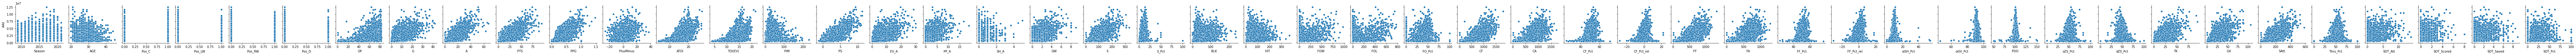

In [17]:
sns.pairplot(skaters, x_vars=['Season', 'AGE', 'Pos_C', 'Pos_LW', 'Pos_RW', 'Pos_D', 'GP','G', 'A', 'PTS', 'PPG', 
                              'PlusMinus', 'ATOI', 'TOI(EV)', 'PIM', 'PS','EV_A', 'PP_A', 'SH_A', 'GW', 'S', 'S_Pct', 
                              'BLK', 'HIT', 'FOW', 'FOL','FO_Pct', 'CF', 'CA', 'CF_Pct', 'CF_Pct_rel', 'FF', 'FA', 
                              'FF_Pct','FF_Pct_rel', 'oiSH_Pct', 'oiSV_Pct', 'PDO', 'oZS_Pct', 'dZS_Pct', 'TK','GV',
                              'SAtt.', 'Thru_Pct', 'SOT_Att', 'SOT_Scored', 'SOT_Saved','SOT_Pct'],
            y_vars= ['AAV'])

# First Glance
First we will build some rough-draft pipelines to get a bit better understanding of the dataset and what type of regressor(s) to use moving forward.


**Pipeline 1: StandardScaler, SelectKBest, LinearRegression**

In [18]:
# define pipeline

pipe_sl= make_pipeline(StandardScaler(), SelectKBest(score_func=f_regression), LinearRegression())

In [19]:
# fit pipeline

pipe_sl.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>)),
                ('linearregression', LinearRegression())])

In [20]:
# assess performance

cv_results= cross_validate(pipe_sl, X_train, y_train, cv=5)

In [21]:
np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

(0.661930373238703, 0.029825127414325223)

In [22]:
pipe_sl.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [23]:
# hyperparameter search with gridsearchcv

In [24]:
k = [k+1 for k in range(len(X_train.columns))]
grid = {'selectkbest__k': k}

In [25]:
lr_grid_cv= GridSearchCV(pipe_sl, param_grid=grid, cv=5, n_jobs=-1)

In [26]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [27]:
score_mean= lr_grid_cv.cv_results_['mean_test_score']
score_std= lr_grid_cv.cv_results_['std_test_score']
cv_k= [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [28]:
lr_grid_cv.best_params_

{'selectkbest__k': 48}

In [29]:
np.mean(score_mean), np.mean(score_std)

(0.6820046831393404, 0.030703956297514257)

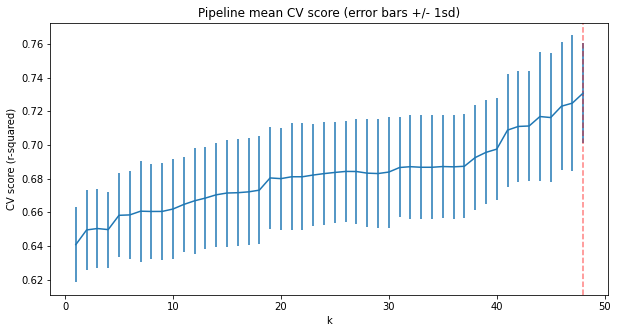

In [30]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

A pipeline using a all 48 features an average R2 score of 0.661930373238703, with an avg standard deviation 0.029825127414325223.
After performing a GridSearch to find the optimal parameters for this linear model, the model improved slightly with an average R2 of 0.6820046831393404 with a standadrd deviation of 0.030703956297514257. This means that, using this model, we can explain approximately 68% of the target variable with the feature set.

So far, this is not a bad model, but it is worth exploring more.


**Pipeline 2: RobustScaler, SelectKBest, LinearRegression**

In [191]:
pipe_rl= make_pipeline(RobustScaler(), SelectKBest(score_func=f_regression), LinearRegression())
pipe_rl.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>)),
                ('linearregression', LinearRegression())])

In [32]:
cv_results= cross_validate(pipe_rl, X_train, y_train, cv=5)
np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

(0.6619162074979194, 0.029805662703688427)

In [34]:
lr_grid_cv= GridSearchCV(pipe_rl, param_grid=grid, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [35]:
score_mean= lr_grid_cv.cv_results_['mean_test_score']
score_std= lr_grid_cv.cv_results_['std_test_score']
cv_k= [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [36]:
np.mean(score_mean), np.mean(score_std)

(0.6820078814831015, 0.030725752775320973)

In [213]:
lr_grid_cv.best_params_

{'selectkbest__k': 48}

Using a RobustScaler rather than a StandardScaler does not produce significantly better results.

**Pipeline 3: Random Forest Regressor**

In [223]:
rf_pipe= make_pipeline(RandomForestRegressor(random_state=47))

In [224]:
rf_cv_results= cross_validate(rf_pipe, X_train, y_train, cv=5)

In [225]:
np.mean(rf_cv_results['test_score']), np.std(rf_cv_results['test_score'])

(0.7678326554340307, 0.024159314918945202)

In [226]:

n_est = [int(n) for n in [5,10,20,30,40,50,60,70,80,90,100]]

grid_params= {
    'randomforestregressor__n_estimators': n_est,
}

In [227]:
rf_grid_cv= GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [228]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [5, 10, 20, 30,
                                                                 40, 50, 60, 70,
                                                                 80, 90, 100]})

In [229]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 80}

In [230]:
best_scores= cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
best_scores= best_scores['test_score']
np.mean(best_scores), np.std(best_scores)

(0.7680762074871137, 0.02427305358317436)

This pipeline used a Random Forest and resulted in our best model yet, yielding an R2 score of 0.7680762074871137 with a standard deviation of 0.02427305358317436. A GridSearch identified the ideal amount of estimators/trees to be 80.
These are promising results because it suggests that our ideal model would be found through a tree-based approach.

In [231]:
#quantity assessement

In [233]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(rf_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

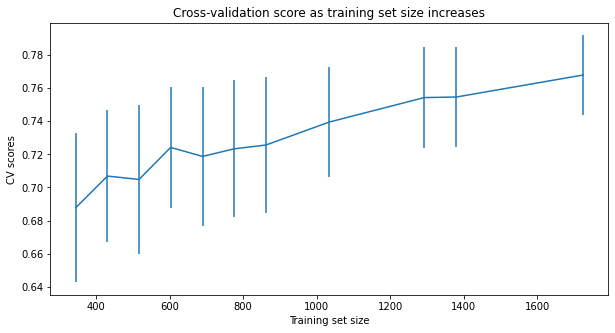

In [234]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

Now, compare these results with the Linear Regression model from Pipeline 2

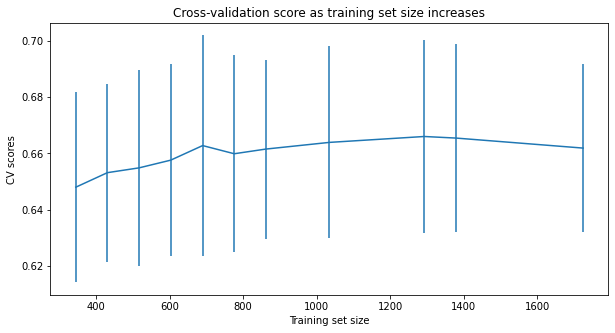

In [235]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe_rl, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

**Pipeline 4: Extra Trees Regressor, SelectKBest, Robust Scaler**

In [236]:
ef_pipe1 = make_pipeline(SelectKBest(score_func=f_regression), ExtraTreesRegressor(random_state=47))

In [237]:
ef_pipe1.get_params()

{'memory': None,
 'steps': [('selectkbest',
   SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>)),
  ('extratreesregressor', ExtraTreesRegressor(random_state=47))],
 'verbose': False,
 'selectkbest': SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>),
 'extratreesregressor': ExtraTreesRegressor(random_state=47),
 'selectkbest__k': 10,
 'selectkbest__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>,
 'extratreesregressor__bootstrap': False,
 'extratreesregressor__ccp_alpha': 0.0,
 'extratreesregressor__criterion': 'squared_error',
 'extratreesregressor__max_depth': None,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__max_leaf_nodes': None,
 'extratreesregressor__max_samples': None,
 'extratreesregressor__min_impurity_decrease': 0.0,
 'extratreesregressor__min_samples_leaf': 1,
 'extratreesregressor__min_samples_split': 2,
 'extratreesregressor__min_weight_fraction_leaf'

In [238]:
ef_pipe1.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000027DA44499D0>)),
                ('extratreesregressor', ExtraTreesRegressor(random_state=47))])

In [239]:
cv_results= cross_validate(ef_pipe1, X_train, y_train, cv=5)

In [240]:
np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

(0.6753847995002871, 0.02997850258065238)

In [ ]:
################################################

In [241]:
ef_pipe2= make_pipeline( ExtraTreesRegressor( random_state=47, max_depth= None))
ef_pipe2.fit(X_train, y_train)
cv_results= cross_validate(ef_pipe2, X_train, y_train, cv=5)
np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

(0.7652222318886996, 0.02108761518801243)

In [242]:
extra_params= {
    'extratreesregressor__criterion': ['mse','mae'],
     'extratreesregressor__max_depth': [None, 4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
    'extratreesregressor__max_features':['auto', 'sqrt','log2', 45],
    'extratreesregressor__n_estimators':[5,10,20,30,40,50,60,65,70,80,90,100]
}

ep= {
    'extratreesregressor__criterion': ['mse'],
     'extratreesregressor__max_depth': [22,23,24],
    'extratreesregressor__max_features':['auto'],
    'extratreesregressor__n_estimators':[96,97,98]
}
#65,70,80,85,90, 


In [243]:
ef_grid_cv= GridSearchCV(ef_pipe2, param_grid=ep, cv=5, n_jobs=-1)

In [244]:
#ef_grid_cv.get_params().keys()

In [245]:
ef_grid_cv.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [22, 23, 24],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [96, 97, 98]})

In [246]:
cv_results= cross_validate(ef_grid_cv, X_train, y_train, cv=5)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

In [247]:
np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

(0.7705839346478099, 0.02286312357924583)

In [248]:
ef_grid_cv.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 22,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 97}

# This section will dive into feature selection. First a Random Forest Regressor is utilized to determine which features are the most important for the model.

Text(0.5, 0, 'Random Forest Feature Importance')

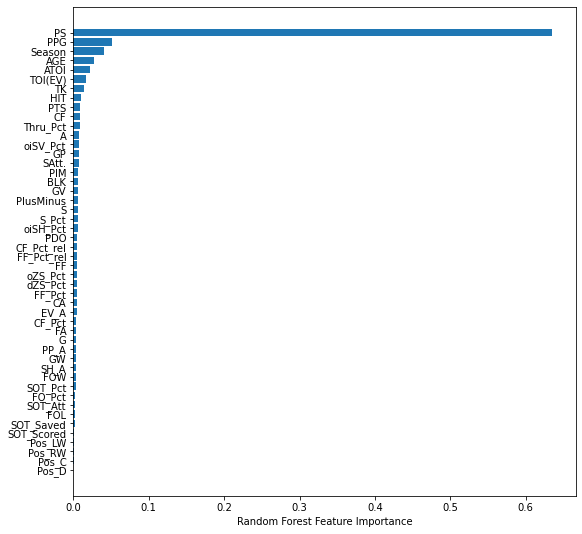

In [249]:
rf= RandomForestRegressor(n_estimators=80, random_state=47)
rf.fit(X_train, y_train)
rf.feature_importances_

plt.figure(figsize= (9,9))
sorted_idx= rf.feature_importances_.argsort()[:]
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel('Random Forest Feature Importance')

## Feature sets
- all
- top 10 rf
- top 20 rf
- heatmap 20
- top 30 rf
- custom 10 features



In [23]:
#####  Hyperparameters

params= {
    'extratreesregressor__criterion': ['mse','mae'],
    'extratreesregressor__max_depth': [None,4,5,6,15,16,17,18,19,20,21,22,23,25,28,30],
    'extratreesregressor__max_features':['auto'],
    'extratreesregressor__n_estimators':[60,61,62,63,65,70,75,79,80,89,90,91,92,93,94,95,96,97,98,99]
}
ep= {
    'extratreesregressor__criterion': ['mse'],
    'extratreesregressor__max_depth': [16,17,18,19,20,21,22,23,28],
    'extratreesregressor__max_features':['auto'],
    'extratreesregressor__n_estimators':[63,65,75,79,80,89,90,91,97,99,100,101,105]
}


egp= {
    'extratreesregressor__criterion': ['mse'],
    'extratreesregressor__max_depth': [16,17,18,19,20,21,22,23,28],
    'extratreesregressor__max_features':['auto'],
    'extratreesregressor__n_estimators':[63,64,65,66,67,70,75,79,80,89,90,91,97,99,100,101,105,110,115,120,125,127,128,129,
                                         130,131,132,133,134,135,136,137,138,139,140,150,160]
}

    
bp2={
    'xgbregressor__booster': ['gbtree'],
    'xgbregressor__gamma': [0],
    'xgbregressor__random_state': [47],
    'xgbregressor__max_depth': [2,3,4,5,6,7,8,9],
    'xgbregressor__learning_rate': [0.3,0.1,0.01],
    'xgbregressor__n_estimators': [4,5,6,7,8,9,10,11,12,20,30,40,41,42,45,50,51,52,53,54,55],
    'xgbregressor__tree_method': ['exact'],
    'xgbregressor__objective': ['reg:squarederror'] 
}




bp3={
    'xgbregressor__booster': ['gbtree'],
    'xgbregressor__gamma': [0],
    'xgbregressor__random_state': [47],
    'xgbregressor__max_depth': [2,3,4,5,6,7,8,9,10,12,15],
    'xgbregressor__learning_rate': [0.3],
    'xgbregressor__n_estimators': [31,35,38, 39,40,41,42,43,44 ,45,46,47,50],
    'xgbregressor__tree_method': ['exact'],
    'xgbregressor__objective': ['reg:squarederror'] 
} 


# ----- ------ ------ ------ ------- ------  all features ------- ------ ------ ----- ------- ----- ---- ------

In [11]:
X= skaters.iloc[:,1:-2]
y= skaters.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)


LinearRegression() RobustScaler()
R2 Score on Training: 0.7493712365744245
MAPE on Training: 0.48941336614707437
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999040979987935
MAPE on Training: 0.0011596058291543441
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9699227384746046
MAPE on Training: 0.1435330906421852
------
Ridge() RobustScaler()
R2 Score on Training: 0.7489822047987273
MAPE on Training: 0.48875492361554135
------


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+15, tolerance: 8.110e+11
  model = cd_fast.enet_coordinate_descent(


Lasso() RobustScaler()
R2 Score on Training: 0.7492301338925637
MAPE on Training: 0.489798292022665
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.6830777001403541
MAPE on Training: 0.5209089744597295
------
GradientBoostingRegressor() None
R2 Score on Training: 0.8836420180477395
MAPE on Training: 0.30437567578924585
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7364577291986932
MAPE on Training: 0.5030665367767627
------
SVR() RobustScaler()
R2 Score on Training: -0.17410884587804198
MAPE on Training: 0.6637643673525719
------
RANSACRegressor() RobustScaler()
R2 Score on Training: -3.594350130593635
MAPE on Training: 1.066734519286965
------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan

In [12]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,variable
0,5.561630e+05,Season
1,5.759488e+01,AGE
2,4.268480e+00,Pos_C
3,2.981899e+00,Pos_LW
4,3.138431e+00,Pos_RW
5,2.005067e+01,Pos_D
6,1.707033e+02,GP
7,inf,G
8,inf,A
9,inf,PTS


In [24]:
# find optimal ExtraTrees model

et_all_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_all_pipe.fit(X_train, y_train)

et_all_grid= GridSearchCV(et_all_pipe, param_grid=ep, cv=5, n_jobs=-1)
et_all_grid.fit(X_train, y_train)


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100, 101,
                                                               105]})

In [25]:
et_all_best= et_all_grid.best_estimator_
et_all_grid.best_params_


{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 22,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 97}

In [26]:

cv_results= cross_validate(et_all_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7726342778228024, 0.022121977908206178)

In [27]:
y_pred= et_all_grid.predict(X_test)
print("ExtraTrees, All Features, predicted vs test: %s" % r2_score(y_test, y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, All Features, predicted vs test: 0.7689742517711995
mean absolute pct error: 0.39796850041090187


In [28]:
######################################################################

In [29]:
b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1)
b_grid.fit(X_train, y_train)
xg_all_best= b_grid.best_estimator_
print(b_grid.best_params_)
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, All Features, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 45, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
0.7823499537553069 0.02939468207138658
XGBoost, All Features, predicted vs test: 0.7820942422273066
mean absolute pct error: 0.3840168525336653


In [30]:
#######################################################################

In [31]:
vr_all= VotingRegressor(estimators= [('etc', et_all_best), ('xgb',xg_all_best)])
vr_all.fit(X_train, y_train)
pred= vr_all.predict(X_test)
print("Voting Regressor , all features, predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor , all features, predicted vs test: 0.7878381540510369
mean absolute pct error: 0.3795968462300534


# ----- ------ ------ ------ ------- ------ top 10 rf features ------ ------ ----- ------- ----- ---- ------

In [29]:
top10= skaters[['CF', 'PTS', 'HIT', 'TK', 'TOI(EV)', 'ATOI', 'AGE', 'Season', 'PPG','PS','AAV']]

X= top10.iloc[:,0:-1]
y= top10.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)


LinearRegression() RobustScaler()
R2 Score on Training: 0.7150707505775961
MAPE on Training: 0.5276198517385456
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999043229028806
MAPE on Training: 0.0011347565755910737
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9700331546936896
MAPE on Training: 0.14132388729434053
------
Ridge() RobustScaler()
R2 Score on Training: 0.7150651676202928
MAPE on Training: 0.5277497644928064
------
Lasso() RobustScaler()
R2 Score on Training: 0.7150707504840659
MAPE on Training: 0.5276196640939979
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.665544638427221
MAPE on Training: 0.5397492798046544
------
GradientBoostingRegressor() None
R2 Score on Training: 0.8682818600729646
MAPE on Training: 0.3176132762026512
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7139642039974703
MAPE on Training: 0.5342089684566949
------
SVR() RobustScaler()
R2 Score on Training: -0.17404379986362

In [254]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(top10.values, i) for i in range(top10.shape[1])]
vif['variable'] = top10.columns
vif

,VIF,variable
0,53.130229,CF
1,59.260279,PTS
2,4.408782,HIT
3,11.446213,TK
4,455.424755,TOI(EV)
5,368.132215,ATOI
6,52.673357,AGE
7,100.612361,Season
8,41.601988,PPG
9,26.032748,PS


In [92]:
et_top10_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_top10_pipe.fit(X_train, y_train)

et_top10_grid= GridSearchCV(et_top10_pipe, param_grid=ep, cv=5, n_jobs=-1)
et_top10_grid.fit(X_train, y_train)


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100]})

In [93]:
et_top10_best= et_top10_grid.best_estimator_
et_top10_grid.best_params_

# {'extratreesregressor__criterion': 'mse',
#  'extratreesregressor__max_depth': 20,
#  'extratreesregressor__max_features': 'auto',
#  'extratreesregressor__n_estimators': 79}

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 28,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 100}

In [94]:
cv_results= cross_validate(et_top10_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7734364792828334, 0.022124008826758183)

In [95]:
y_pred= et_top10_grid.predict(X_test)
print("ExtraTrees, Top10 RF, predicted vs test: %s" % r2_score(y_test, y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, Top10 RF, predicted vs test: 0.760957598563817
mean absolute pct error: 0.3996725808638628


In [96]:
##################################################################################

In [97]:

b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1)
b_grid.fit(X_train, y_train)
xg_top10_best=b_grid.best_estimator_
print(b_grid.best_params_)
print('---------')
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, Top 10 RF, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 40, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
---------
0.7846412862124101 0.030738115959360875
XGBoost, Top 10 RF, predicted vs test: 0.7815324351386619
mean absolute pct error: 0.3875441913685276


In [98]:
#################################################################

In [99]:
vr= VotingRegressor(estimators= [('etc', et_top10_best), ('xgb',xg_top10_best)])
vr.fit(X_train, y_train)
pred= vr.predict(X_test)
print("Voting Regressor ,Top 10 rf, predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor ,Top 10 rf, predicted vs test: 0.7833486096823188
mean absolute pct error: 0.3833118716208209


# ----- ------ ------ ------ ------- ------ top 20 rf features ------ ------ ----- ------- ----- ---- ------


In [52]:
top20= skaters[['S', 'PlusMinus', 'GV', 'BLK', 'PIM', 'SAtt.', 'GP', 'oiSV_Pct', 'A', 'Thru_Pct', 'CF', 'PTS',
                'HIT', 'TK', 'TOI(EV)', 'ATOI', 'AGE','Season', 'PPG', 'PS','AAV']]

X= top20.iloc[:,0:-1]
y= top20.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.7307520074033325
MAPE on Training: 0.49536143156535667
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999043063838917
MAPE on Training: 0.0011401729748814343
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9702521000536953
MAPE on Training: 0.14269385092734158
------
Ridge() RobustScaler()
R2 Score on Training: 0.7307381805073033
MAPE on Training: 0.49555720612777004
------
Lasso() RobustScaler()
R2 Score on Training: 0.7307520070719016
MAPE on Training: 0.4953621322378868
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.6798725846730598
MAPE on Training: 0.5185823837804924
------


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e+12, tolerance: 8.110e+11
  model = cd_fast.enet_coordinate_descent(


GradientBoostingRegressor() None
R2 Score on Training: 0.8779251015798117
MAPE on Training: 0.30695954399250924
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7290651378592019
MAPE on Training: 0.4956390110892522
------
SVR() RobustScaler()
R2 Score on Training: -0.17407983554446416
MAPE on Training: 0.6637422430282574
------
RANSACRegressor() RobustScaler()
R2 Score on Training: 0.37751155056405616
MAPE on Training: 0.7322447563515402
------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', vali

In [256]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(top20.values, i) for i in range(top20.shape[1])]
vif['variable'] = top20.columns
vif

,VIF,variable
0,300.628899,S
1,2.402170,PlusMinus
2,12.911102,GV
3,14.173533,BLK
4,4.315019,PIM
5,307.947194,SAtt.
6,121.958578,GP
7,1687.958283,oiSV_Pct
8,69.657564,A
9,80.412480,Thru_Pct


In [53]:
et_top20_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_top20_pipe.fit(X_train, y_train)

et_top20_grid= GridSearchCV(et_top20_pipe, param_grid=ep, cv=5, n_jobs=-1)
et_top20_grid.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100]})

In [54]:
et_top20_best= et_top20_grid.best_estimator_
et_top20_grid.best_params_


{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 16,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 97}

In [55]:
cv_results= cross_validate(et_top20_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7790836940606803, 0.019926278655517143)

In [56]:
y_pred= et_top20_grid.predict(X_test)
print("ExtraTrees, Top 20 RF, predicted vs test: %s" % r2_score(y_test, y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, Top 20 RF, predicted vs test: 0.761356740458938
mean absolute pct error: 0.39738772525834704


In [ ]:
#######################################################################

In [57]:

b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1)
b_grid.fit(X_train, y_train)
xg_top20_best=b_grid.best_estimator_
print(b_grid.best_params_)
print('---------')
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, Top 20 RF, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 50, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
---------
0.7878953901390471 0.03108776601355424
XGBoost, Top 20 RF, predicted vs test: 0.7733339812684187
mean absolute pct error: 0.3905105997900939


In [58]:
########################################################################

In [59]:
vr= VotingRegressor(estimators= [('etc', et_top20_best), ('xgb',xg_top20_best)])
vr.fit(X_train, y_train)
pred= vr.predict(X_test)
print("Voting Regressor , Top 20 rf, predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor , Top 20 rf, predicted vs test: 0.7797879644041675
mean absolute pct error: 0.38422774857587044


# ----- ------ ------ ------ ------- ------20 heatmap features ------ ------ ----- ------- ----- ---- ---


In [60]:
heat= skaters[['Season','AGE','Pos_C','Pos_LW','Pos_RW','Pos_D','PPG','GW','SH_A','PlusMinus','ATOI','PIM','BLK','HIT',
              'FO_Pct','CF_Pct_rel','oiSH_Pct','oiSV_Pct','TK','SOT_Scored','AAV']]

X= heat.iloc[:,0:-1]
y= heat.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.7088807104382026
MAPE on Training: 0.5656013874797006
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999043152772499
MAPE on Training: 0.001137766634505692
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9690051258143402
MAPE on Training: 0.14704423907004324
------
Ridge() RobustScaler()
R2 Score on Training: 0.7088797598924994
MAPE on Training: 0.5653954963307065
------
Lasso() RobustScaler()
R2 Score on Training: 0.7088807104195539
MAPE on Training: 0.5656008759060771
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.6332860849623209
MAPE on Training: 0.5655340899083622
------
GradientBoostingRegressor() None
R2 Score on Training: 0.8771230609486433
MAPE on Training: 0.31644907072197537
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7073632372040479
MAPE on Training: 0.5679032830247704
------
SVR() RobustScaler()
R2 Score on Training: -0.1741266061517

In [258]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(heat.values, i) for i in range(heat.shape[1])]
vif['variable'] = heat.columns
vif

,VIF,variable
0,1752.463772,Season
1,53.951547,AGE
2,3.126439,Pos_C
3,2.742122,Pos_LW
4,2.890948,Pos_RW
5,13.830011,Pos_D
6,27.898776,PPG
7,5.222145,GW
8,1.623299,SH_A
9,1.436347,PlusMinus


In [61]:
et_heat_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_heat_pipe.fit(X_train, y_train)

et_heat_grid= GridSearchCV(et_heat_pipe, param_grid=ep, cv=5, n_jobs=-1)
et_heat_grid.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100]})

In [62]:
et_hm_best=et_heat_grid.best_estimator_
et_heat_grid.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 20,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 91}

In [63]:
cv_results= cross_validate(et_heat_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7756251717402515, 0.029641846850603445)

In [64]:
y_pred= et_heat_grid.predict(X_test)
print("ExtraTrees, 20 HM Features, predicted vs test: %s" % r2_score(y_test, y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, 20 HM Features, predicted vs test: 0.7718101922356086
mean absolute pct error: 0.4135163676049014


In [ ]:
################################################################################

In [65]:


b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1)
b_grid.fit(X_train, y_train)
xg_hm_best =b_grid.best_estimator_
print(b_grid.best_params_)
print('---------')
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, 20 HM Features, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 51, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
---------
0.7902987015591869 0.02952460572743513
XGBoost, 20 HM Features, predicted vs test: 0.7684038188792053
mean absolute pct error: 0.40483515665770115


In [66]:
#######################################################################################

In [67]:
vr= VotingRegressor(estimators= [('etc', et_hm_best), ('xgb',xg_hm_best)])
vr.fit(X_train, y_train)
pred= vr.predict(X_test)
print("Voting Regressor , edited 20 HM Features, predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor , edited 20 HM Features, predicted vs test: 0.7832365946428193
mean absolute pct error: 0.39935165886583546


# ----- ------ ------ ------ ------- ------top 30 rf features --- ------ ------ ----- ------- ----- ---- ---


In [68]:
top30= skaters[['CA', 'FF_Pct', 'dZS_Pct', 'oZS_Pct', 'FF', 'FF_Pct_rel', 'CF_Pct_rel', 'PDO', 'oiSH_Pct', 'S_Pct', 'S',
                'PlusMinus', 'GV', 'BLK', 'PIM', 'SAtt.', 'GP', 'oiSV_Pct', 'A', 'Thru_Pct', 'CF', 'PTS', 'HIT', 'TK',
                'TOI(EV)', 'ATOI', 'AGE', 'Season', 'PPG', 'PS', 'AAV']]

X= top30.iloc[:,0:-1]
y= top30.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.7375322174043508
MAPE on Training: 0.5010453071740447
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999042597900936
MAPE on Training: 0.0011471546734486684
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9697485793239646
MAPE on Training: 0.14279611585453802
------
Ridge() RobustScaler()
R2 Score on Training: 0.7370500610956177
MAPE on Training: 0.49972545069627533
------
Lasso() RobustScaler()
R2 Score on Training: 0.7374505383520813
MAPE on Training: 0.5009311549826877
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.6767295754376615
MAPE on Training: 0.5255187095910867
------


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+15, tolerance: 8.110e+11
  model = cd_fast.enet_coordinate_descent(


GradientBoostingRegressor() None
R2 Score on Training: 0.8848532266832427
MAPE on Training: 0.3041087912968846
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7325275785704464
MAPE on Training: 0.5076371961480474
------
SVR() RobustScaler()
R2 Score on Training: -0.17407938638575615
MAPE on Training: 0.6637639488323841
------
RANSACRegressor() RobustScaler()
R2 Score on Training: -35.77784935259655
MAPE on Training: 1.844501446994719
------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validat

In [260]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(top30.values, i) for i in range(top30.shape[1])]
vif['variable'] = top30.columns
vif

,VIF,variable
0,319.813416,CA
1,740.089376,FF_Pct
2,139037.450636,dZS_Pct
3,144922.414066,oZS_Pct
4,2528.855133,FF
5,15.294018,FF_Pct_rel
6,14.910747,CF_Pct_rel
7,4369.315172,PDO
8,49.106927,oiSH_Pct
9,7.778734,S_Pct


In [76]:
et_top30_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_top30_pipe.fit(X_train, y_train)

et_top30_grid= GridSearchCV(et_top30_pipe, param_grid=ep, cv=5, n_jobs=-1)
et_top30_grid.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100]})

In [77]:
et_top30_best= et_top30_grid.best_estimator_
et_top30_grid.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 28,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 100}

In [78]:
cv_results= cross_validate(et_top30_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7734364792828334, 0.022124008826758183)

In [79]:
y_pred= et_top30_grid.predict(X_test)
print("ExtraTrees, Top 30 RF, predicted vs test: %s" % r2_score(y_test, y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, Top 30 RF, predicted vs test: 0.760957598563817
mean absolute pct error: 0.3996725808638628


In [80]:
###########################################################################

In [81]:


b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
b_grid.fit(X_train, y_train)
xg_top30_best= b_grid.best_estimator_
print(b_grid.best_params_)
print('---------')
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, Top 30 RF, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 40, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
---------
0.7846412862124101 0.030738115959360875
XGBoost, Top 30 RF, predicted vs test: 0.7815324351386619
mean absolute pct error: 0.3875441913685276


In [82]:
###################################################################################

In [83]:
vr= VotingRegressor(estimators= [('etc', et_top30_best), ('xgb',xg_top30_best)])
vr.fit(X_train, y_train)
pred= vr.predict(X_test)
print("Voting Regressor , Top 30 rf, predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor , Top 30 rf, predicted vs test: 0.7833486096823188
mean absolute pct error: 0.3833118716208209


# ----- ------ ------ ------ ------- -----custom 18 features --- ------ ------ ----- ------- ----- ------


In [415]:
custom= skaters[['Season','AGE','Pos_D','G','A','GP','PlusMinus','ATOI','PIM','S','BLK','HIT','CF','oiSH_Pct',
                 'oiSV_Pct','PDO','TK','SOT_Scored','AAV']]

X= custom.iloc[:,0:-1]
y= custom.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.7203837188081772
MAPE on Training: 0.501230239357578
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999042932519314
MAPE on Training: 0.0011415537606850295
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9678140936619654
MAPE on Training: 0.1457131739634636
------
Ridge() RobustScaler()
R2 Score on Training: 0.7203783646739702
MAPE on Training: 0.5011858598845744
------
Lasso() RobustScaler()
R2 Score on Training: 0.7203837187729298
MAPE on Training: 0.5012296204925791
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.6394205562775872
MAPE on Training: 0.5437670085499392
------
GradientBoostingRegressor() None
R2 Score on Training: 0.8769348091618776
MAPE on Training: 0.3115462294469573
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7190195353250554
MAPE on Training: 0.5070212665595898
------
SVR() RobustScaler()
R2 Score on Training: -0.174107996170461

In [262]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(custom.values, i) for i in range(custom.shape[1])]
vif['variable'] = custom.columns
vif

,VIF,variable
0,1709.744568,Season
1,53.608815,AGE
2,7.151973,Pos_D
3,18.468756,G
4,18.010035,A
5,94.069835,GP
6,1.448747,PlusMinus
7,121.703223,ATOI
8,4.214495,PIM
9,35.870126,S


In [416]:
et_cust18_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_cust18_pipe.fit(X_train, y_train)

et_cust18_grid= GridSearchCV(et_cust18_pipe, param_grid=ep, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
et_cust18_grid.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [417]:
et_c18_best= et_cust18_grid.best_estimator_
et_cust18_grid.best_params_


{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 16,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 91}

In [418]:
cv_results= cross_validate(et_cust18_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7611710300379952, 0.019028518750886927)

In [419]:
y_pred= et_cust18_grid.predict(X_test)
print("ExtraTrees, Custom set (18 Features), predicted vs test: %s" % r2_score(y_test, y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, Custom set (18 Features), predicted vs test: 0.7648402160499446
mean absolute pct error: 0.4132213849910106


In [ ]:
########################################################################

In [420]:


b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
b_grid.fit(X_train, y_train)
xg_c18_best =b_grid.best_estimator_
print(b_grid.best_params_)
print('---------')
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, Custom set (18 Features), predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 44, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
---------
0.7688570326438209 0.032791016663086835
XGBoost, Custom set (18 Features), predicted vs test: 0.7807796635108487
mean absolute pct error: 0.38155015871028247


In [421]:
##########################################################################################

In [422]:
vr= VotingRegressor(estimators= [('etc', et_c18_best), ('xgb',xg_c18_best)])
vr.fit(X_train, y_train)
pred= vr.predict(X_test)
print("Voting Regressor , Custom set (18 Features), predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor , Custom set (18 Features), predicted vs test: 0.7874620360843152
mean absolute pct error: 0.3852379537602327


# ----- ------ ------ ------ ------- -----custom3, rf 10 edited (oisv)--- ------ ------ ----- ---- ----


In [111]:
top10_edited= skaters[['CF', 'PTS', 'HIT', 'TK', 'oiSV_Pct', 'ATOI', 'AGE', 'Season', 'PPG','PS','AAV']]

X= top10_edited.iloc[:,0:-1]
y= top10_edited.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.7146823741787973
MAPE on Training: 0.5305081575040796
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999043150306403
MAPE on Training: 0.0011363371800164324
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9701743818656823
MAPE on Training: 0.14154530405012264
------
Ridge() RobustScaler()
R2 Score on Training: 0.7146789347982099
MAPE on Training: 0.5305069217950271
------
Lasso() RobustScaler()
R2 Score on Training: 0.7146823741368934
MAPE on Training: 0.53050706328228
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.6625078518984764
MAPE on Training: 0.5304794428910892
------
GradientBoostingRegressor() None
R2 Score on Training: 0.8687171768387918
MAPE on Training: 0.31740802715574057
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.7141429380704392
MAPE on Training: 0.5350124199562064
------
SVR() RobustScaler()
R2 Score on Training: -0.17405955684269

In [266]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(top10_edited.values, i) for i in range(top10_edited.shape[1])]
vif['variable'] = top10_edited.columns
vif

,VIF,variable
0,50.020726,CF
1,55.935415,PTS
2,4.367522,HIT
3,11.183011,TK
4,1537.512761,oiSV_Pct
5,68.847964,ATOI
6,50.073318,AGE
7,1670.226037,Season
8,42.933662,PPG
9,26.717631,PS


In [113]:
et_top10E_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_top10E_pipe.fit(X_train, y_train)

et_top10E_grid= GridSearchCV(et_top10E_pipe, param_grid=ep, cv=5, n_jobs=-1)
et_top10E_grid.fit(X_train, y_train)


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 65, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100]})

In [114]:
et_10e_best=et_top10E_grid.best_estimator_
et_top10E_grid.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 20,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 63}

In [115]:
cv_results= cross_validate(et_top10E_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.7812674961618661, 0.020893824071695093)

In [116]:
y_pred= et_10e_best.predict(X_test)
print("ExtraTrees, edited Top 10 rf, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

ExtraTrees, edited Top 10 rf, predicted vs test: 0.7640197827353615
mean absolute pct error: 0.39807736865072957


In [439]:
###############################################################

In [117]:


b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp3, cv=5, n_jobs=-1)
b_grid.fit(X_train, y_train)
print(b_grid.best_params_)
xgb_10e_best = b_grid.best_estimator_
print('---------')
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, edited Top 10 rf, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 41, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
---------
0.788117632021729 0.029538635063856834
XGBoost, edited Top 10 rf, predicted vs test: 0.7706906479477984
mean absolute pct error: 0.3899386679794038


In [441]:
########################################################################################

In [118]:
vr= VotingRegressor(estimators= [('etc', et_10e_best), ('xgb',xgb_10e_best)])

In [119]:
vr.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


VotingRegressor(estimators=[('etc',
                             Pipeline(steps=[('extratreesregressor',
                                              ExtraTreesRegressor(criterion='mse',
                                                                  max_depth=20,
                                                                  n_estimators=63,
                                                                  random_state=47))])),
                            ('xgb',
                             Pipeline(steps=[('xgbregressor',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           gamma=0, gpu_i

In [120]:
pred= vr.predict(X_test)

In [121]:
print("Voting Regressor , edited Top 10 rf, predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

Voting Regressor , edited Top 10 rf, predicted vs test: 0.778331967357941
mean absolute pct error: 0.3859876471577174


# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

### **Save best model**

In [ ]:
##########################################################################################

In [32]:
best_model= vr_all
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns= [col for col in X_train.columns]
best_model.build_datetime= datetime.datetime.now()

filename= r'D:\Springboard Course\Assignments\Springboard\NHL Salary Predictor\Models/skater_model.pkl'
joblib.dump(best_model, filename)

['D:\\Springboard Course\\Assignments\\Springboard\\NHL Salary Predictor\\Models/skater_model.pkl']

# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

In [51]:
vr_all.named_estimators_

{'etc': Pipeline(steps=[('extratreesregressor',
                  ExtraTreesRegressor(criterion='mse', max_depth=22,
                                      n_estimators=97, random_state=47))]),
 'xgb': Pipeline(steps=[('xgbregressor',
                  XGBRegressor(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=45, n_jobs=8, num_parallel_tree=1,
                               predictor='auto', random_state=47, reg_alpha=0,
                               reg_lambda=1, scale_pos_weight=1, subsample=1,
            

In [72]:
best_model= joblib.load('../Models/skater_model.pkl')

In [82]:
X= skaters.iloc[:,1:-2]
y= skaters.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

y_pred= best_model.predict(X_test)
print("R2 score: %s " %r2_score(y_test, y_pred))
print("Mean absolute error: %s " % mean_absolute_error(y_test, y_pred))
print("Mean absolute percentage error: %s " % mean_absolute_percentage_error(y_test, y_pred))


R2 score: 0.7878381540510369 
Mean absolute error: 577929.6797209606 
Mean absolute percentage error: 0.3795968462300534 


In [53]:
def min_sal(x):
    if x == 2009:
        return 475000
    elif x == 2010:
        return 500000
    elif x == 2011:
        return 500000
    elif x == 2012:
        return 525000
    elif x == 2013:
        return 525000
    elif x == 2014:
        return 550000
    elif x == 2015:
        return 550000
    elif x == 2016:
        return 575000
    elif x == 2017:
        return 575000
    elif x == 2018:
        return 650000
    elif x == 2019:
        return 650000
    elif x == 2020:
        return 700000
    elif x == 2021:
        return 750000

def apply_sal(pred,minsal):
    if pred > minsal:
        return pred
    else:
        return minsal
    

In [83]:
s_test=y_test

In [77]:
s_combo = X_test
s_combo['y_pred'] = y_pred

s_combo['min_salary'] = s_combo['Season'].map(min_sal)

s_combo['y_pred_new']= s_combo.apply(lambda x: apply_sal(x['y_pred'], x['min_salary']), axis=1)

In [78]:
s_combo.head()

,Season,AGE,Pos_C,Pos_LW,Pos_RW,Pos_D,GP,G,A,PTS,PPG,PlusMinus,ATOI,TOI(EV),PIM,PS,EV_A,PP_A,SH_A,GW,S,S_Pct,BLK,HIT,FOW,FOL,FO_Pct,CF,CA,CF_Pct,CF_Pct_rel,FF,FA,FF_Pct,FF_Pct_rel,oiSH_Pct,oiSV_Pct,PDO,oZS_Pct,dZS_Pct,TK,GV,SAtt.,Thru_Pct,SOT_Att,SOT_Scored,SOT_Saved,SOT_Pct,y_pred,min_salary,y_pred_new
2601,2009,24.0,0,0,1,0,40.000000,8.000000,5.000000,13.000000,0.325000,-8.000000,12.733333,11.116667,8.000000,1.100000,7.000000,1.000000,0.000000,1.000000,47.000000,17.000000,13.000000,54.000000,4.000000,4.000000,50.000000,360.000000,422.000000,46.000000,-3.200000,273.000000,319.000000,46.100000,-3.400000,6.300000,90.100000,96.500000,53.900000,46.100000,21.000000,11.000000,71.000000,66.200000,0.0,0.0,0.0,0.000000,9.188463e+05,475000,9.188463e+05
270,2019,21.0,0,1,1,0,79.000000,36.666667,24.666667,61.333333,0.776371,-3.000000,17.211111,14.105556,30.666667,7.733333,22.000000,14.666667,0.000000,5.333333,230.000000,16.033333,40.000000,74.666667,7.333333,18.000000,20.766667,1031.333333,1102.333333,48.366667,-1.833333,780.000000,831.000000,48.433333,-1.933333,11.133333,90.533333,101.700000,57.600000,42.400000,33.333333,51.333333,432.000000,53.500000,5.0,2.0,3.0,44.433333,6.855222e+06,650000,6.855222e+06
157,2020,25.0,0,1,1,0,51.333333,6.000000,4.333333,10.333333,0.201299,-8.666667,12.366667,10.788889,8.666667,0.300000,5.333333,0.000000,0.666667,0.333333,72.000000,8.733333,38.666667,137.000000,9.666667,20.000000,33.566667,448.000000,596.666667,42.600000,-7.433333,342.333333,435.000000,44.033333,-6.666667,6.533333,91.900000,98.466667,30.700000,69.300000,21.666667,9.666667,127.666667,55.133333,0.0,0.0,0.0,0.000000,1.039448e+06,700000,1.039448e+06
1745,2013,36.0,0,0,1,0,69.333333,29.666667,32.333333,62.000000,0.894231,-5.000000,20.116667,16.350000,38.000000,7.633333,20.333333,9.333333,0.000000,4.666667,224.666667,12.666667,28.000000,97.333333,188.000000,176.333333,51.333333,1042.333333,1117.666667,48.500000,-1.633333,771.666667,824.333333,48.666667,-1.233333,9.633333,90.266667,99.933333,51.133333,48.866667,36.666667,48.333333,395.000000,57.433333,0.0,0.0,0.0,0.000000,6.571361e+06,525000,6.571361e+06
132,2020,29.0,1,0,0,0,69.000000,12.666667,15.000000,27.666667,0.400966,3.333333,14.833333,12.461111,18.000000,2.533333,11.000000,0.333333,1.333333,2.000000,96.000000,12.266667,32.000000,66.666667,423.000000,410.333333,50.533333,803.666667,843.333333,48.900000,-5.600000,593.333333,632.666667,48.533333,-6.033333,8.333333,92.100000,100.466667,50.700000,49.300000,44.666667,28.666667,167.333333,58.166667,0.0,0.0,0.0,0.000000,3.067143e+06,700000,3.067143e+06


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


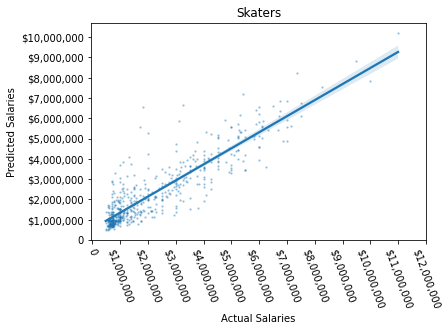

In [80]:
xticks=[0, 1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000,11000000,12000000]
yticks=[0, 1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000]
xtlabels=['0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000','$7,000,000','$8,000,000','$9,000,000','$10,000,000','$11,000,000','$12,000,000']
ytlabels=['0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000','$7,000,000','$8,000,000','$9,000,000','$10,000,000']

sns.regplot(y_test, s_combo["y_pred_new"],scatter_kws={'s':2, 'alpha':0.3})
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.xticks(ticks= xticks, labels=xtlabels, rotation=290)
plt.yticks(ticks= yticks, labels=ytlabels, rotation=0)
plt.title('Skaters')
plt.show()

In [81]:
print("R2 score: %s " %r2_score(y_test, s_combo['y_pred_new']))
print("Mean absolute error: %s " % mean_absolute_error(y_test, s_combo['y_pred_new']))
print("Mean absolute percentage error: %s " % mean_absolute_percentage_error(y_test, s_combo['y_pred_new']))

R2 score: 0.787841597997626 
Mean absolute error: 577789.6283677826 
Mean absolute percentage error: 0.379352671463598 


original scores

R2 score: 0.7878381540510369

Mean absolute error: 577929.6797209606 

Mean absolute percentage error: 0.3795968462300534 

While the model does a relatively good job of producing a residual plot that is linear overall, this model has a tendency to over-predict salaries for players that actually make $1-2 million annually. 

# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

# GOALIES

In [6]:
goalies.head()

,Player,Season,AGE,GP,PTS,SOT_Att,SOT_Scored,SOT_Saved,SOT_Pct,GS,W,L,TplusOTL,GA,SA,SV,SV_Pct,GAA,SUT,GPS,MIN,QS,RBS,LENGTH,AAV
0,Thatcher Demko,2021,25.0,23.666667,0.333333,8.333333,1.333333,7.000000,83.333333,22.666667,11.0,10.333333,1.333333,67.333333,758.000000,690.666667,0.911000,2.906667,0.333333,4.566667,1383.333333,13.333333,3.333333,5,5000000.0
1,Jordan Binnington,2021,27.0,41.333333,0.666667,12.000000,3.333333,8.666667,73.633333,40.333333,24.0,10.666667,5.333333,97.666667,1145.666667,1048.000000,0.916333,2.366667,2.666667,7.233333,2424.000000,23.000000,3.666667,6,6000000.0
2,Cory Schneider,2021,34.0,26.000000,0.000000,9.000000,5.000000,4.000000,44.400000,23.000000,6.0,13.000000,4.000000,70.000000,718.000000,648.000000,0.903000,3.060000,1.000000,3.400000,1372.000000,10.000000,5.000000,1,700000.0
3,Craig Anderson,2021,39.0,50.000000,2.000000,2.000000,2.000000,0.000000,0.000000,47.000000,17.0,27.000000,4.000000,163.000000,1676.000000,1513.000000,0.903000,3.510000,2.000000,8.100000,2785.000000,19.000000,8.000000,1,700000.0
4,Anthony Stolarz,2021,27.0,13.000000,0.500000,4.500000,1.500000,3.000000,75.000000,9.500000,4.0,4.000000,1.500000,33.500000,366.500000,333.000000,0.913500,2.825000,1.000000,2.050000,666.500000,5.000000,1.500000,2,950000.0


In [60]:
X= goalies.iloc[:,1:-2]
y= goalies.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

Feature Importances

Text(0.5, 0, 'Random Forest Feature Importance')

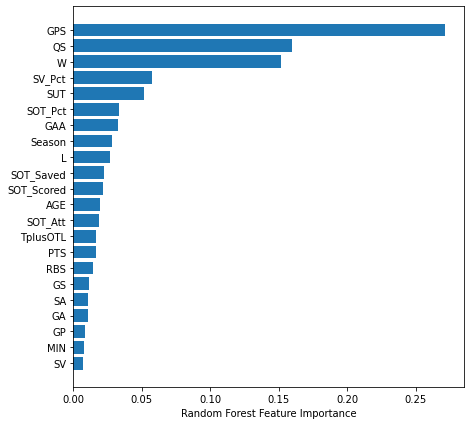

In [168]:
rf= RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.feature_importances_

plt.figure(figsize= (7,7))
sorted_idx= rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel('Random Forest Feature Importance')

# ----- ------ ------ ------ ------- ------ --- all goalie features ------ ------ ----- ------- ----- -------

In [291]:
X= goalies.iloc[:,1:-2]
y= goalies.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)

results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.6499511046415307
MAPE on Training: 0.5018876287264536
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 1.0
MAPE on Training: 0.0
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9330509366229188
MAPE on Training: 0.2098847845289423
------
Ridge() RobustScaler()
R2 Score on Training: 0.638830350825379
MAPE on Training: 0.5071060800370147
------
Lasso() RobustScaler()
R2 Score on Training: 0.6485214182075898
MAPE on Training: 0.5063010028373433
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.550054146710912
MAPE on Training: 0.5539447161439662
------
GradientBoostingRegressor() None
R2 Score on Training: 0.9685495172446132
MAPE on Training: 0.15527774158473856
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.6205680657103017
MAPE on Training: 0.5156822489957998
------
SVR() RobustScaler()
R2 Score on Training: -0.15475107128575671
MAPE on Training: 0.6633641364

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e+14, tolerance: 8.893e+10
  model = cd_fast.enet_coordinate_descent(


RANSACRegressor() RobustScaler()
R2 Score on Training: 0.055769211647960004
MAPE on Training: 0.8352983125012133
------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) None
R2 Score on Training: 0.9999999967130947
MAPE on Training: 4.679907157390753e-05
------
AdaBoostRegressor() None
R2 Score on Training: 0.8030297909209256
MAPE on Training: 0.5003602988868089


In [180]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,variable
0,8.693721e+04,Season
1,6.305977e+01,AGE
2,1.412302e+03,GP
3,2.949280e+00,PTS
4,inf,SOT_Att
5,inf,SOT_Scored
6,inf,SOT_Saved
7,2.191476e+01,SOT_Pct
8,2.034769e+03,GS
9,7.179008e+02,W


In [287]:
et_GAll_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_GAll_pipe.fit(X_train, y_train)

et_GAll_grid= GridSearchCV(et_GAll_pipe, param_grid=egp, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
et_GAll_grid.fit(X_train, y_train)

et_GAll_best=et_GAll_grid.best_estimator_
print(et_GAll_grid.best_params_)

cv_results= cross_validate(et_GAll_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))

y_pred= et_GAll_grid.predict(X_test)
print("All Features: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


{'extratreesregressor__criterion': 'mse', 'extratreesregressor__max_depth': 22, 'extratreesregressor__max_features': 'auto', 'extratreesregressor__n_estimators': 130}


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

0.5156333432692929 0.14325727526679002
All Features: 0.33182419816772335
mean absolute pct error: 0.6483080890419993


In [ ]:
#################################################

### xgb 1 with 4 depth, 4 est

In [294]:
b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp2, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
b_grid.fit(X_train, y_train)

xg_best= b_grid.best_estimator_
print(b_grid.best_params_)

cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))

y_pred= b_grid.predict(X_test)

print("XGBoost, All Features, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))



{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 4, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
0.3610164538365733 0.1141222395558554
XGBoost, All Features, predicted vs test: 0.4816380121140078
mean absolute pct error: 0.4318444705575881


### xgb 2 with 3 depth, 5 est

In [295]:
b= make_pipeline(XGBRegressor(booster='gbtree',gamma=0, learning_rate=0.3, max_depth=3, n_estimators=5, objective=
                                 'reg:squarederror', random_state=47, tree_method='exact'))
b.fit(X_train, y_train)

cv_results= cross_validate(b, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))

y_pred= b.predict(X_test)
print("All Features: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

0.4160196057210156 0.12392460453874835
All Features: 0.5044129860522961
mean absolute pct error: 0.5012297971873815


### voting regressor

In [298]:
vr= VotingRegressor(estimators= [('etc', et_GAll_best), ('xgb',b)])
vr.fit(X_train, y_train)
pred= vr.predict(X_test)
print("Voting Regressor , Custom set (18 Features), predicted vs test: %s" % r2_score(y_test,pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, pred))

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Voting Regressor , Custom set (18 Features), predicted vs test: 0.4763649369925431
mean absolute pct error: 0.5538329677176842


# ----- ------ ------ ------ ------- ----- top 10 rf features ------- ------ ------ ----- ------- ----- -----


In [35]:
gtop10= goalies[['AGE', 'Season', 'GAA', 'L', 'SUT', 'SOT_Pct', 'SV_Pct', 'QS', 'W','GPS','AAV']]

X= gtop10.iloc[:,0:-1]
y= gtop10.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)


results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.6160782159303139
MAPE on Training: 0.508410585856603
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 1.0
MAPE on Training: 0.0
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9375945929625839
MAPE on Training: 0.20205046666271378
------
Ridge() RobustScaler()
R2 Score on Training: 0.614832084821106
MAPE on Training: 0.5116865048699581
------
Lasso() RobustScaler()
R2 Score on Training: 0.6160782158912075
MAPE on Training: 0.5084103229263455
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.5386825251906768
MAPE on Training: 0.5753147920356744
------
GradientBoostingRegressor() None
R2 Score on Training: 0.9502106248171128
MAPE on Training: 0.19060409198953798
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.6086307878460065
MAPE on Training: 0.5192074073587555
------
SVR() RobustScaler()
R2 Score on Training: -0.15475533484210868
MAPE on Training: 0.663360649

In [36]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(gtop10.values, i) for i in range(gtop10.shape[1])]
vif['variable'] = gtop10.columns
vif

,VIF,variable
0,63.594781,AGE
1,64010.936391,Season
2,407.749000,GAA
3,28.631396,L
4,8.885290,SUT
5,14.621250,SOT_Pct
6,55689.913119,SV_Pct
7,185.835290,QS
8,74.982010,W
9,153.707286,GPS


In [37]:
et_G10rf_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_G10rf_pipe.fit(X_train, y_train)

et_G10rf_grid= GridSearchCV(et_G10rf_pipe, param_grid=egp, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
et_G10rf_grid.fit(X_train, y_train)



C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 64, 65, 66,
                                                               67, 70, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100, 101,
                                                               105, 110, 115,
                                                               120, 125, 127,
                                          

In [38]:
et_G10rf_best= et_G10rf_grid.best_estimator_
et_G10rf_grid.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 22,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 130}

In [39]:
cv_results= cross_validate(et_G10rf_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.5156333432692929, 0.14325727526679002)

In [40]:
y_pred= et_G10rf_grid.predict(X_test)
print("Top 10: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

Top 10: 0.33182419816772335
mean absolute pct error: 0.6483080890419993


In [257]:
##########################################################

In [333]:
b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp2, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
b_grid.fit(X_train, y_train)

xg_best= b_grid.best_estimator_
print(b_grid.best_params_)

cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))

y_pred= b_grid.predict(X_test)

print("XGBoost, top10, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))



{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 3, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
0.19167316380464555 0.14140158857921836
XGBoost, top10, predicted vs test: 0.3165522552411665
mean absolute pct error: 0.429965794433209


In [11]:
################################################################

In [42]:
b= make_pipeline(XGBRegressor(booster='gbtree',gamma=0, learning_rate=0.3, max_depth=3, n_estimators=4, objective=
                                 'reg:squarederror', random_state=47, tree_method='exact'))
b.fit(X_train, y_train)

cv_results= cross_validate(b, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))

y_pred= b.predict(X_test)
print("All Features: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

0.4013117687802349 0.12641720680754087
All Features: 0.4515544489538339
mean absolute pct error: 0.43151086656171644


# ----- ------ ------ ------ ------- ----- top 14 rf features ------- ------ ------ ----- ------- ----- -----


In [89]:
gtop14= goalies[['SOT_Saved', 'PTS', 'SOT_Att', 'TplusOTL', 'AGE', 'Season', 'GAA', 'L',
                 'SUT', 'SOT_Pct', 'SV_Pct', 'QS', 'W', 'GPS','AAV']]

X= gtop14.iloc[:,0:-1]
y= gtop14.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)


results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.6297700604573055
MAPE on Training: 0.5183580713526149
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 1.0
MAPE on Training: 0.0
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9344809099520069
MAPE on Training: 0.2068246216942937
------
Ridge() RobustScaler()
R2 Score on Training: 0.6276921900849182
MAPE on Training: 0.5177179387037537
------
Lasso() RobustScaler()
R2 Score on Training: 0.6297700602834821
MAPE on Training: 0.5183567332564019
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.5427131395538487
MAPE on Training: 0.563785682330677
------
GradientBoostingRegressor() None
R2 Score on Training: 0.9586861876912055
MAPE on Training: 0.17718196232290234
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.6075704879344184
MAPE on Training: 0.5276476836677267
------
SVR() RobustScaler()
R2 Score on Training: -0.15475431408433526
MAPE on Training: 0.663362616

In [11]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(gtop14.values, i) for i in range(gtop14.shape[1])]
vif['variable'] = gtop14.columns
vif

,VIF,variable
0,112.225956,SOT_Saved
1,2.890892,PTS
2,122.591922,SOT_Att
3,14.026909,TplusOTL
4,65.639335,AGE
5,71653.857005,Season
6,418.219397,GAA
7,30.474494,L
8,9.034102,SUT
9,21.213559,SOT_Pct


In [13]:
et_G14rf_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_G14rf_pipe.fit(X_train, y_train)

et_G14rf_grid= GridSearchCV(et_G14rf_pipe, param_grid=egp, cv=5, n_jobs=-1)
et_G14rf_grid.fit(X_train, y_train)



C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 64, 65, 66,
                                                               67, 70, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100, 101,
                                                               105, 110, 115,
                                                               120, 125, 127,
                                          

In [32]:
et_GA14rf_best=et_G14rf_grid.best_estimator_
et_G14rf_grid.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 18,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 65}

In [15]:
cv_results= cross_validate(et_G14rf_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.5166164999264613, 0.14697546788785235)

In [16]:
y_pred= et_G14rf_grid.predict(X_test)
print("Top 14: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

Top 14: 0.2028865193779411
mean absolute pct error: 0.6821581163603221


In [ ]:
############################################################

In [13]:
b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp2, cv=5, n_jobs=-1, scoring= 'neg_mean_absolute_percentage_error')
b_grid.fit(X_train, y_train)
print(b_grid.best_params_)
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("XGBoost, top 14, predicted vs test: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 11, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
0.2613645882071714 0.10754145825174208
XGBoost, top 14, predicted vs test: 0.38146316834691296
mean absolute pct error: 0.4104105396203971


In [90]:
b_gbest= make_pipeline(XGBRegressor(booster='gbtree',gamma=0, learning_rate=0.3, max_depth=4, n_estimators=4, objective=
                                 'reg:squarederror', random_state=47, tree_method='exact'))
b_gbest.fit(X_train, y_train)
cv_results= cross_validate(b, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_gbest.predict(X_test)
print("Top 14 Features: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

0.4934676781947732 0.09535135575235014
Top 14 Features: 0.4911512714834073
mean absolute pct error: 0.4126450427962703


In [85]:
g_test= y_test

In [93]:
g_combo = X_test
g_combo['y_pred'] = y_pred

g_combo['min_salary'] = g_combo['Season'].map(min_sal)

g_combo['y_pred_new']= g_combo.apply(lambda x: apply_sal(x['y_pred'], x['min_salary']), axis=1)

In [94]:
df_combo.head()

,Season,AGE,Pos_C,Pos_LW,Pos_RW,Pos_D,GP,G,A,PTS,PPG,PlusMinus,ATOI,TOI(EV),PIM,PS,EV_A,PP_A,SH_A,GW,S,S_Pct,BLK,HIT,FOW,FOL,FO_Pct,CF,CA,CF_Pct,CF_Pct_rel,FF,FA,FF_Pct,FF_Pct_rel,oiSH_Pct,oiSV_Pct,PDO,oZS_Pct,dZS_Pct,TK,GV,SAtt.,Thru_Pct,SOT_Att,SOT_Scored,SOT_Saved,SOT_Pct,y_pred,min_salary,y_pred_new
2601,2009,24.0,0,0,1,0,40.000000,8.000000,5.000000,13.000000,0.325000,-8.000000,12.733333,11.116667,8.000000,1.100000,7.000000,1.000000,0.000000,1.000000,47.000000,17.000000,13.000000,54.000000,4.000000,4.000000,50.000000,360.000000,422.000000,46.000000,-3.200000,273.000000,319.000000,46.100000,-3.400000,6.300000,90.100000,96.500000,53.900000,46.100000,21.000000,11.000000,71.000000,66.200000,0.0,0.0,0.0,0.000000,9.188463e+05,475000,9.188463e+05
270,2019,21.0,0,1,1,0,79.000000,36.666667,24.666667,61.333333,0.776371,-3.000000,17.211111,14.105556,30.666667,7.733333,22.000000,14.666667,0.000000,5.333333,230.000000,16.033333,40.000000,74.666667,7.333333,18.000000,20.766667,1031.333333,1102.333333,48.366667,-1.833333,780.000000,831.000000,48.433333,-1.933333,11.133333,90.533333,101.700000,57.600000,42.400000,33.333333,51.333333,432.000000,53.500000,5.0,2.0,3.0,44.433333,6.855222e+06,650000,6.855222e+06
157,2020,25.0,0,1,1,0,51.333333,6.000000,4.333333,10.333333,0.201299,-8.666667,12.366667,10.788889,8.666667,0.300000,5.333333,0.000000,0.666667,0.333333,72.000000,8.733333,38.666667,137.000000,9.666667,20.000000,33.566667,448.000000,596.666667,42.600000,-7.433333,342.333333,435.000000,44.033333,-6.666667,6.533333,91.900000,98.466667,30.700000,69.300000,21.666667,9.666667,127.666667,55.133333,0.0,0.0,0.0,0.000000,1.039448e+06,700000,1.039448e+06
1745,2013,36.0,0,0,1,0,69.333333,29.666667,32.333333,62.000000,0.894231,-5.000000,20.116667,16.350000,38.000000,7.633333,20.333333,9.333333,0.000000,4.666667,224.666667,12.666667,28.000000,97.333333,188.000000,176.333333,51.333333,1042.333333,1117.666667,48.500000,-1.633333,771.666667,824.333333,48.666667,-1.233333,9.633333,90.266667,99.933333,51.133333,48.866667,36.666667,48.333333,395.000000,57.433333,0.0,0.0,0.0,0.000000,6.571361e+06,525000,6.571361e+06
132,2020,29.0,1,0,0,0,69.000000,12.666667,15.000000,27.666667,0.400966,3.333333,14.833333,12.461111,18.000000,2.533333,11.000000,0.333333,1.333333,2.000000,96.000000,12.266667,32.000000,66.666667,423.000000,410.333333,50.533333,803.666667,843.333333,48.900000,-5.600000,593.333333,632.666667,48.533333,-6.033333,8.333333,92.100000,100.466667,50.700000,49.300000,44.666667,28.666667,167.333333,58.166667,0.0,0.0,0.0,0.000000,3.067143e+06,700000,3.067143e+06


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


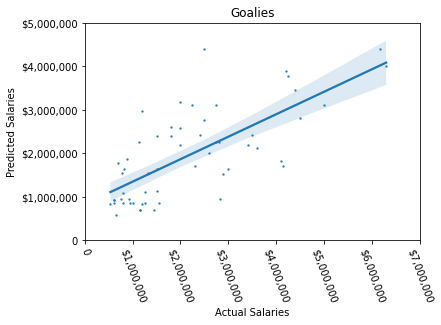

In [128]:
xticks=[0, 1000000,2000000,3000000,4000000,5000000,6000000,7000000]
yticks=[0, 1000000,2000000,3000000,4000000,5000000]
ytlabels=['0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000']
xtlabels=['0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000','$7,000,000']

sns.regplot(y_test, g_combo['y_pred_new'],scatter_kws={'s':2})
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.xticks(ticks= xticks, labels=xtlabels, rotation=290)
plt.yticks(ticks= yticks, labels=ytlabels, rotation=0)
plt.title('Goalies')
plt.show()

In [127]:
max(g_test)

6300000.0

In [68]:
print("R2 score: %s " %r2_score(y_test, df_combo['y_pred_new']))
print("Mean absolute error: %s " % mean_absolute_error(y_test, df_combo['y_pred_new']))
print("Mean absolute percentage error: %s " % mean_absolute_percentage_error(y_test, df_combo['y_pred_new']))

R2 score: 0.4911553268879101 
Mean absolute error: 790448.379385965 
Mean absolute percentage error: 0.41256188658844306 


In [65]:
best_model= b_gbest
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns= [col for col in X_train.columns]
best_model.build_datetime= datetime.datetime.now()

filename= r'D:\Springboard Course\Assignments\Springboard\NHL Salary Predictor\Models/goalie_model.pkl'
joblib.dump(best_model, filename)

['D:\\Springboard Course\\Assignments\\Springboard\\NHL Salary Predictor\\Models/goalie_model.pkl']

# ----- ------ ------ ------ ------- ----- custom 8 features ------- ------ ------ ----- ------- ----- ---


In [90]:
gcustom8= goalies[['GP','Season','W','GPS','GAA','SV_Pct','SOT_Pct','AGE','AAV']]

X= gcustom8.iloc[:,0:-1]
y= gcustom8.iloc[:, -1]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=12)


results(RobustScaler(), LinearRegression(), X_train, y_train)
print('------')
results(None, ExtraTreesRegressor(random_state=47), X_train, y_train)
print('------')
results(None, RandomForestRegressor(random_state=47), X_train, y_train)
print('------')
results(RobustScaler(), Ridge(), X_train, y_train)
print('------')
results(RobustScaler(), Lasso(), X_train, y_train)
print('------')
results(RobustScaler(), ElasticNet(), X_train, y_train)
print('------')
results(None, GradientBoostingRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SGDRegressor(), X_train, y_train)
print('------')
results(RobustScaler(), SVR(), X_train, y_train)
print('------')
results(RobustScaler(), RANSACRegressor(), X_train, y_train)
print('------')
results(None, XGBRegressor(), X_train, y_train)
print('------')
results(None, AdaBoostRegressor(), X_train, y_train)

LinearRegression() RobustScaler()
R2 Score on Training: 0.6281489986376476
MAPE on Training: 0.5195381668120346
------
ExtraTreesRegressor(random_state=47) None
R2 Score on Training: 0.9999999994377808
MAPE on Training: 4.47547440028643e-06
------
RandomForestRegressor(random_state=47) None
R2 Score on Training: 0.9384791479765351
MAPE on Training: 0.19966580678814685
------
Ridge() RobustScaler()
R2 Score on Training: 0.6243881313172903
MAPE on Training: 0.5200357697067644
------
Lasso() RobustScaler()
R2 Score on Training: 0.6281489985711453
MAPE on Training: 0.5195372894380507
------
ElasticNet() RobustScaler()
R2 Score on Training: 0.5247037569594183
MAPE on Training: 0.5997275163996447
------
GradientBoostingRegressor() None
R2 Score on Training: 0.9469902905178571
MAPE on Training: 0.20194256671412586
------
SGDRegressor() RobustScaler()
R2 Score on Training: 0.6243866095541833
MAPE on Training: 0.5204677129780141
------
SVR() RobustScaler()
R2 Score on Training: -0.1547546571457

In [89]:
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(gcustom8.values, i) for i in range(gcustom8.shape[1])]
vif['variable'] = gcustom8.columns
vif

,VIF,variable
0,137.481068,GP
1,63562.727190,Season
2,53.152932,W
3,114.801507,GPS
4,321.175079,GAA
5,56050.367091,SV_Pct
6,13.994209,SOT_Pct
7,63.317276,AGE
8,6.717752,AAV


In [69]:
et_G8_pipe= make_pipeline(ExtraTreesRegressor(random_state=47, max_depth=None))
et_G8_pipe.fit(X_train, y_train)

et_G8_grid= GridSearchCV(et_G8_pipe, param_grid=egp, cv=5, n_jobs=-1)
et_G8_grid.fit(X_train, y_train)

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('extratreesregressor',
                                        ExtraTreesRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'extratreesregressor__criterion': ['mse'],
                         'extratreesregressor__max_depth': [16, 17, 18, 19, 20,
                                                            21, 22, 23, 28],
                         'extratreesregressor__max_features': ['auto'],
                         'extratreesregressor__n_estimators': [63, 64, 65, 66,
                                                               67, 70, 75, 79,
                                                               80, 89, 90, 91,
                                                               97, 99, 100, 101,
                                                               105, 110, 115,
                                                               120, 125, 127,
                                          

In [70]:
et_G8_grid.best_params_

{'extratreesregressor__criterion': 'mse',
 'extratreesregressor__max_depth': 18,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__n_estimators': 63}

In [71]:
cv_results= cross_validate(et_G8_grid.best_estimator_, X_train, y_train, cv=5)

np.mean(cv_results['test_score']), np.std(cv_results['test_score'])

C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

(0.5216556508484539, 0.1371558456996376)

In [77]:
y_pred= et_G8_grid.predict(X_test)
print("Custom 8: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

Custom 8: 0.32535833704040074
mean absolute pct error: 0.6391117552401043


In [88]:
b= make_pipeline(XGBRegressor())
b.fit(X_train, y_train)

b_grid= GridSearchCV(b, param_grid=bp2, cv=5, n_jobs=-1, scoring= 'neg_mean_absolute_percentage_error')
b_grid.fit(X_train, y_train)
print(b_grid.best_params_)
cv_results= cross_validate(b_grid.best_estimator_, X_train, y_train, cv=5)
print(np.mean(cv_results['test_score']), np.std(cv_results['test_score']))
y_pred= b_grid.predict(X_test)
print("All Features: %s" % r2_score(y_test,y_pred))
print('mean absolute pct error: %s' % mean_absolute_percentage_error(y_test, y_pred))

{'xgbregressor__booster': 'gbtree', 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 12, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__random_state': 47, 'xgbregressor__tree_method': 'exact'}
0.32465787990845885 0.0946367607985269
All Features: 0.38609362018341997
mean absolute pct error: 0.4524339041381483


# ----- ------ ------ ------ ------- ------ ------ ----- ---- ------- ------ ------ ----- ------- ----- ---- ------

The best model for goalies appears to be an XGBoost Regressor with a max depth of 4 and 4 estimators. Using a Random Forest Regressor to identify the most important features for Goalies' salaries, a feature set with only the top 14 features gave us the model with the most accurate results and lowest mean absolute percentage error.

In [102]:
best_model= b_gbest
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns= [col for col in X_train.columns]
best_model.build_datetime= datetime.datetime.now()

filename= r'D:\Springboard Course\Assignments\Springboard\NHL Salary Predictor\Models/goalie_model.pkl'
joblib.dump(best_model, filename)

['D:\\Springboard Course\\Assignments\\Springboard\\NHL Salary Predictor\\Models/goalie_model.pkl']

In [110]:
df_combo= pd.DataFrame()

df_combo['test']= pd.concat([s_test, g_test])
df_combo['y_new']= pd.concat([s_combo['y_pred_new'], g_combo['y_pred_new']])

In [111]:
df_combo

,test,y_new
2601,837500.0,9.188463e+05
270,6750000.0,6.855222e+06
157,1225000.0,1.039448e+06
1745,1800000.0,6.571361e+06
132,2250000.0,3.067143e+06
...,...,...
21,1500000.0,2.396587e+06
228,2833333.0,9.370983e+05
172,1450000.0,6.858227e+05
223,1800000.0,2.406518e+06


C:\Users\essmar\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


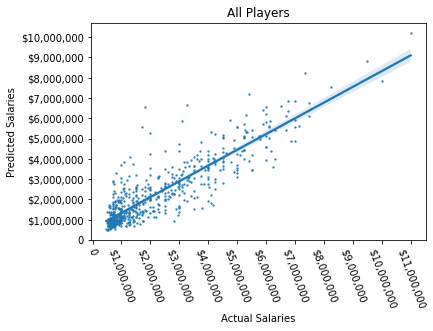

In [120]:
xticks=[0, 1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000,11000000]
yticks=[0, 1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000]
xtlabels=['0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000','$7,000,000','$8,000,000','$9,000,000','$10,000,000','$11,000,000']
ytlabels=['0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000','$7,000,000','$8,000,000','$9,000,000','$10,000,000']


sns.regplot(df_combo['test'], df_combo['y_new'],scatter_kws={'s':2})
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.xticks(ticks= xticks, labels=xtlabels, rotation=290)
plt.yticks(ticks= yticks, labels=ytlabels, rotation=0)
plt.title('All Players')
plt.show()

In [119]:
max(df_combo['test'])

11000000.0

In [121]:
print("R2 Score: %s" % r2_score(df_combo['test'], df_combo['y_new']))
print("Mean Absolute Error: %s" % mean_absolute_error(df_combo['test'], df_combo['y_new']))
print("Mean Absolute Percentage Error: %s" % mean_absolute_percentage_error(df_combo['test'], df_combo['y_new']))

R2 Score: 0.7702093984288202
Mean Absolute Error: 598093.7302237899
Mean Absolute Percentage Error: 0.38252340054586964
